In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 40  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=100 #"local batch size: B"
    bs=100 #"test batch size"
    lr=0.03 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD' #'ADAM'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        dict_users = cifar_noniid(dataset_train, args.num_users)
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

In [4]:
N = args.num_users

p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)

[0.1 0.3 0.4 0.3 0.3 0.5 0.1 0.3 0.4 0.2 0.4 0.2 0.4 0.4 0.5 0.2 0.5 0.2
 0.4 0.5 0.3 0.2 0.4 0.4 0.5 0.5 0.1 0.4 0.1 0.5 0.3 0.2 0.2 0.5 0.3 0.4
 0.5 0.5 0.4 0.2]


In [5]:
def ModelDiff_tensor(w1,w2):
    w_avg = copy.deepcopy(w1)
    w1_np = np.zeros((1,1))
    w2_np = np.zeros((1,1))
    for k in w_avg.keys():
        tmp1 = w1[k].cpu().detach().numpy()
        tmp2 = w2[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape)
        
        tmp1 = np.reshape(tmp1,(1,_d))
        tmp2 = np.reshape(tmp2,(1,_d))
        
        dist = tmp1 - tmp2
        
        pow1 = np.matmul(tmp1, tmp1.transpose())
        pow2 = np.matmul(tmp2, tmp2.transpose())
        
        dist_l2 = np.matmul(dist, dist.transpose())
        
#         print(k,cur_shape)
#         print(pow1, pow2, dist_l2)
#         print()
        
        w1_np = np.concatenate([w1_np,tmp1], axis=1)
        w2_np = np.concatenate([w2_np,tmp2], axis=1)
    
    w1_l2 = np.matmul(w1_np, w1_np.transpose())
    w2_l2 = np.matmul(w2_np, w2_np.transpose())
    
    dist = w1_np - w2_np
    dist_l2 = np.matmul(dist, dist.transpose())
    
    print(w1_l2, w2_l2, dist_l2)
    
    return dist_l2/w1_l2

def ModelDiff_np(w1,w2):
    cur_shape = w1.shape
    _d = np.prod(cur_shape)
    
    tmp1 = np.reshape(w1,(1,_d))
    tmp2 = np.reshape(w2,(1,_d))
        
    dist = tmp1 - tmp2
        
    pow1 = np.matmul(tmp1, tmp1.transpose())
    pow2 = np.matmul(tmp2, tmp2.transpose())
        
    dist_l2 = np.matmul(dist, dist.transpose())
    
    print(pow1, pow2, dist_l2)
    
    return dist_l2/pow1

In [6]:
from models.Nets import *
def tensor_dim(w0):
    model_dim = 0
    
    w_avg = copy.deepcopy(w0)

    for k in w_avg.keys():
        tmp1 = w0[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape)
        
        model_dim = model_dim + _d
        
    return model_dim

net_glob = CNNMnist3(args)
net_glob = net_glob.cuda()

net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

d = tensor_dim(w_glob)

print(d)

62346


In [7]:
from models.Nets import *
import pickle

p = 0
N = 40
K = 8

N_trials = 1
Max_iter = 400

lr_array = [0.03]

acc_test_arr  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr = np.zeros((len(lr_array), N_trials, Max_iter))



P_random = []


for trial_idx in range(N_trials):
    

    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNMnist2(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        w_glob_array = []
        w_locals_array = []
        
        for iter in range(Max_iter): #args.epochs
            
            if iter >= 200:
                args.lr = lr_array[lr_idx] * 0.1
            elif iter >= 300:
                args.lr = lr_array[lr_idx] * 0.01
            
            w_locals, loss_locals = [], []
            w_locals_all = []
            
#             u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)

            ###############################
            # 1. Random Selection
            ###############################
            idxs_users = np.random.choice(result[0], K, replace=False)

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)

#             print('Learning Rate =',args.lr)
        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in range(N):
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                
                w_locals_all.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
                
                if idx in idxs_users:
                    w_locals.append(copy.deepcopy(w))
            
            
                
                
            # update global weights
            w_glob = FedAvg(w_locals)
            
            
            w_locals_array.append(w_locals_all)
            w_glob_array.append(w_glob)
            
            ModelDiff_tensor(net_glob.state_dict(), w_glob_array[iter])     
            
            # copy weight to net_glob
            if iter < 500:
                print('net_glob is updated !!')
                net_glob.load_state_dict(w_glob)
#             else:
#                 net_glob.load_state_dict(w_glob_prev)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)
            
# filehandler = open("./save_models/MNIST_CNN_N40_K8_w_locals_array_Maxiter"+str(Max_iter),"wb")
# pickle.dump(w_locals_array, filehandler)

# filehandler = open("./save_models/MNIST_CNN_N40_K8_w_glob_array_Maxiter"+str(Max_iter),"wb")
# pickle.dump(w_glob_array, filehandler)
            


Learning Rate = 0.03

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)
[[35.31202944]] [[35.8765838]] [[0.26753488]]
net_glob is updated !!

Test set: Average loss: 1.9165 
Accuracy: 4026/10000 (40.26%)

Round   0, Train average loss 2.152 Test accuracy 40.260
[[35.8765838]] [[37.47843597]] [[0.48986032]]
net_glob is updated !!

Test set: Average loss: 1.2368 
Accuracy: 6118/10000 (61.18%)

Round   1, Train average loss 1.600 Test accuracy 61.180
[[37.47843597]] [[38.66248373]] [[0.14775934]]
net_glob is updated !!

Test set: Average loss: 1.1252 
Accuracy: 6584/10000 (65.84%)

Round   2, Train average loss 1.224 Test accuracy 65.840
[[38.66248373]] [[39.54896333]] [[0.07640478]]
net_glob is updated !!

Test set: Average loss: 0.9960 
Accuracy: 6847/10000 (68.47%)

Round   3, Train average loss 1.083 Test accuracy 68.470
[[39.54896333]] [[4

[[49.47925616]] [[49.58778393]] [[0.00315312]]
net_glob is updated !!

Test set: Average loss: 0.0535 
Accuracy: 9837/10000 (98.37%)

Round  42, Train average loss 0.070 Test accuracy 98.370
[[49.58778393]] [[49.68000209]] [[0.00307202]]
net_glob is updated !!

Test set: Average loss: 0.0542 
Accuracy: 9839/10000 (98.39%)

Round  43, Train average loss 0.069 Test accuracy 98.390
[[49.68000209]] [[49.80159044]] [[0.00318779]]
net_glob is updated !!

Test set: Average loss: 0.0537 
Accuracy: 9838/10000 (98.38%)

Round  44, Train average loss 0.068 Test accuracy 98.380
[[49.80159044]] [[49.90893545]] [[0.00282306]]
net_glob is updated !!

Test set: Average loss: 0.0513 
Accuracy: 9840/10000 (98.40%)

Round  45, Train average loss 0.067 Test accuracy 98.400
[[49.90893545]] [[50.01404213]] [[0.00226231]]
net_glob is updated !!

Test set: Average loss: 0.0507 
Accuracy: 9846/10000 (98.46%)

Round  46, Train average loss 0.066 Test accuracy 98.460
[[50.01404213]] [[50.12880001]] [[0.00317188]

[[53.15293003]] [[53.21817781]] [[0.00291759]]
net_glob is updated !!

Test set: Average loss: 0.0394 
Accuracy: 9873/10000 (98.73%)

Round  85, Train average loss 0.045 Test accuracy 98.730
[[53.21817781]] [[53.28876663]] [[0.00236856]]
net_glob is updated !!

Test set: Average loss: 0.0372 
Accuracy: 9879/10000 (98.79%)

Round  86, Train average loss 0.045 Test accuracy 98.790
[[53.28876663]] [[53.36846683]] [[0.00226055]]
net_glob is updated !!

Test set: Average loss: 0.0382 
Accuracy: 9880/10000 (98.80%)

Round  87, Train average loss 0.045 Test accuracy 98.800
[[53.36846683]] [[53.44562147]] [[0.00174035]]
net_glob is updated !!

Test set: Average loss: 0.0375 
Accuracy: 9878/10000 (98.78%)

Round  88, Train average loss 0.045 Test accuracy 98.780
[[53.44562147]] [[53.51390911]] [[0.00170359]]
net_glob is updated !!

Test set: Average loss: 0.0377 
Accuracy: 9877/10000 (98.77%)

Round  89, Train average loss 0.044 Test accuracy 98.770
[[53.51390911]] [[53.57028157]] [[0.0022357]]


Test set: Average loss: 0.0318 
Accuracy: 9898/10000 (98.98%)

Round 128, Train average loss 0.035 Test accuracy 98.980
[[55.58119324]] [[55.61847687]] [[0.00192476]]
net_glob is updated !!

Test set: Average loss: 0.0314 
Accuracy: 9889/10000 (98.89%)

Round 129, Train average loss 0.035 Test accuracy 98.890
[[55.61847687]] [[55.66730445]] [[0.0024342]]
net_glob is updated !!

Test set: Average loss: 0.0325 
Accuracy: 9893/10000 (98.93%)

Round 130, Train average loss 0.035 Test accuracy 98.930
[[55.66730445]] [[55.69842745]] [[0.00246083]]
net_glob is updated !!

Test set: Average loss: 0.0325 
Accuracy: 9895/10000 (98.95%)

Round 131, Train average loss 0.035 Test accuracy 98.950
[[55.69842745]] [[55.74960194]] [[0.00237097]]
net_glob is updated !!

Test set: Average loss: 0.0324 
Accuracy: 9895/10000 (98.95%)

Round 132, Train average loss 0.034 Test accuracy 98.950
[[55.74960194]] [[55.80196774]] [[0.00170806]]
net_glob is updated !!

Test set: Average loss: 0.0318 
Accuracy: 989


Test set: Average loss: 0.0301 
Accuracy: 9896/10000 (98.96%)

Round 171, Train average loss 0.029 Test accuracy 98.960
[[57.33873643]] [[57.36907516]] [[0.00151825]]
net_glob is updated !!

Test set: Average loss: 0.0305 
Accuracy: 9892/10000 (98.92%)

Round 172, Train average loss 0.028 Test accuracy 98.920
[[57.36907516]] [[57.40738936]] [[0.00205632]]
net_glob is updated !!

Test set: Average loss: 0.0295 
Accuracy: 9899/10000 (98.99%)

Round 173, Train average loss 0.028 Test accuracy 98.990
[[57.40738936]] [[57.44918303]] [[0.00221092]]
net_glob is updated !!

Test set: Average loss: 0.0295 
Accuracy: 9906/10000 (99.06%)

Round 174, Train average loss 0.028 Test accuracy 99.060
[[57.44918303]] [[57.48131229]] [[0.00197407]]
net_glob is updated !!

Test set: Average loss: 0.0295 
Accuracy: 9899/10000 (98.99%)

Round 175, Train average loss 0.028 Test accuracy 98.990
[[57.48131229]] [[57.52092271]] [[0.00220378]]
net_glob is updated !!

Test set: Average loss: 0.0297 
Accuracy: 99


Test set: Average loss: 0.0281 
Accuracy: 9906/10000 (99.06%)

Round 214, Train average loss 0.022 Test accuracy 99.060
[[58.35046464]] [[58.35027896]] [[3.1409324e-05]]
net_glob is updated !!

Test set: Average loss: 0.0282 
Accuracy: 9907/10000 (99.07%)

Round 215, Train average loss 0.022 Test accuracy 99.070
[[58.35027896]] [[58.3510858]] [[3.2222828e-05]]
net_glob is updated !!

Test set: Average loss: 0.0281 
Accuracy: 9906/10000 (99.06%)

Round 216, Train average loss 0.022 Test accuracy 99.060
[[58.3510858]] [[58.35129837]] [[2.58269174e-05]]
net_glob is updated !!

Test set: Average loss: 0.0282 
Accuracy: 9907/10000 (99.07%)

Round 217, Train average loss 0.022 Test accuracy 99.070
[[58.35129837]] [[58.35224524]] [[3.44575794e-05]]
net_glob is updated !!

Test set: Average loss: 0.0281 
Accuracy: 9906/10000 (99.06%)

Round 218, Train average loss 0.022 Test accuracy 99.060
[[58.35224524]] [[58.35241334]] [[2.7015588e-05]]
net_glob is updated !!

Test set: Average loss: 0.028

[[58.38308153]] [[58.38492997]] [[2.82603907e-05]]
net_glob is updated !!

Test set: Average loss: 0.0276 
Accuracy: 9911/10000 (99.11%)

Round 257, Train average loss 0.021 Test accuracy 99.110
[[58.38492997]] [[58.38749153]] [[3.87675864e-05]]
net_glob is updated !!

Test set: Average loss: 0.0276 
Accuracy: 9909/10000 (99.09%)

Round 258, Train average loss 0.021 Test accuracy 99.090
[[58.38749153]] [[58.38897841]] [[4.80548872e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9911/10000 (99.11%)

Round 259, Train average loss 0.021 Test accuracy 99.110
[[58.38897841]] [[58.39024448]] [[2.88624555e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9910/10000 (99.10%)

Round 260, Train average loss 0.021 Test accuracy 99.100
[[58.39024448]] [[58.39047226]] [[5.56998852e-05]]
net_glob is updated !!

Test set: Average loss: 0.0277 
Accuracy: 9914/10000 (99.14%)

Round 261, Train average loss 0.021 Test accuracy 99.140
[[58.39047226]] [[58.3916


Test set: Average loss: 0.0275 
Accuracy: 9909/10000 (99.09%)

Round 299, Train average loss 0.020 Test accuracy 99.090
[[58.43689443]] [[58.43963805]] [[5.33391809e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9908/10000 (99.08%)

Round 300, Train average loss 0.020 Test accuracy 99.080
[[58.43963805]] [[58.44009529]] [[3.29595092e-05]]
net_glob is updated !!

Test set: Average loss: 0.0276 
Accuracy: 9911/10000 (99.11%)

Round 301, Train average loss 0.020 Test accuracy 99.110
[[58.44009529]] [[58.44032859]] [[3.5355035e-05]]
net_glob is updated !!

Test set: Average loss: 0.0276 
Accuracy: 9909/10000 (99.09%)

Round 302, Train average loss 0.020 Test accuracy 99.090
[[58.44032859]] [[58.4417986]] [[2.30422943e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9911/10000 (99.11%)

Round 303, Train average loss 0.020 Test accuracy 99.110
[[58.4417986]] [[58.44265496]] [[2.26021397e-05]]
net_glob is updated !!

Test set: Average loss: 0.0

[[58.48972287]] [[58.49159535]] [[3.35325633e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9909/10000 (99.09%)

Round 342, Train average loss 0.020 Test accuracy 99.090
[[58.49159535]] [[58.49268464]] [[2.77065617e-05]]
net_glob is updated !!

Test set: Average loss: 0.0274 
Accuracy: 9910/10000 (99.10%)

Round 343, Train average loss 0.020 Test accuracy 99.100
[[58.49268464]] [[58.49498174]] [[3.45589242e-05]]
net_glob is updated !!

Test set: Average loss: 0.0274 
Accuracy: 9909/10000 (99.09%)

Round 344, Train average loss 0.020 Test accuracy 99.090
[[58.49498174]] [[58.49731654]] [[2.76338578e-05]]
net_glob is updated !!

Test set: Average loss: 0.0272 
Accuracy: 9910/10000 (99.10%)

Round 345, Train average loss 0.020 Test accuracy 99.100
[[58.49731654]] [[58.49895153]] [[4.00444439e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9910/10000 (99.10%)

Round 346, Train average loss 0.020 Test accuracy 99.100
[[58.49895153]] [[58.4992


Test set: Average loss: 0.0275 
Accuracy: 9908/10000 (99.08%)

Round 384, Train average loss 0.020 Test accuracy 99.080
[[58.5425236]] [[58.54550408]] [[2.00561622e-05]]
net_glob is updated !!

Test set: Average loss: 0.0274 
Accuracy: 9909/10000 (99.09%)

Round 385, Train average loss 0.020 Test accuracy 99.090
[[58.54550408]] [[58.54673146]] [[2.85666431e-05]]
net_glob is updated !!

Test set: Average loss: 0.0274 
Accuracy: 9910/10000 (99.10%)

Round 386, Train average loss 0.020 Test accuracy 99.100
[[58.54673146]] [[58.54868766]] [[2.78501244e-05]]
net_glob is updated !!

Test set: Average loss: 0.0275 
Accuracy: 9911/10000 (99.11%)

Round 387, Train average loss 0.020 Test accuracy 99.110
[[58.54868766]] [[58.54962099]] [[2.44124916e-05]]
net_glob is updated !!

Test set: Average loss: 0.0274 
Accuracy: 9913/10000 (99.13%)

Round 388, Train average loss 0.020 Test accuracy 99.130
[[58.54962099]] [[58.5519081]] [[2.99361735e-05]]
net_glob is updated !!

Test set: Average loss: 0.

In [14]:
filehandler = open("./save_models/MNIST_CNN_N40_K8_w_locals_array_Maxiter"+str(Max_iter),"wb")
pickle.dump(w_locals_array, filehandler)

filehandler = open("./save_models/MNIST_CNN_N40_K8_w_glob_array_Maxiter"+str(Max_iter),"wb")
pickle.dump(w_glob_array, filehandler)

c:\programdata\anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [15]:
# print((P_random[322]))
filehandler = open("./save_models/MNIST_CNN_N40_K8_P_random_Maxiter"+str(Max_iter),"wb")
pickle.dump(P_random, filehandler)

In [7]:
import pickle

w_locals_array = pickle.load(open('./save_models/MNIST_CNN_N40_K8_w_locals_array_Maxiter400','rb'))
w_glob_array = pickle.load(open('./save_models/MNIST_CNN_N40_K8_w_glob_array_Maxiter400','rb'))
P_random = pickle.load(open('./save_models/MNIST_CNN_N40_K8_P_random_Maxiter400','rb'))

In [8]:
# pickle.load("./save_models/MNIST_CNN_N40_K8_w_glob_iter"+str(iter))
ModelDiff_tensor(w_locals_array[150][0], w_locals_array[150][5])
ModelDiff_tensor(w_locals_array[250][0], w_locals_array[250][5])
ModelDiff_tensor(w_locals_array[350][0], w_locals_array[350][5])     
ModelDiff_tensor(w_glob_array[245], w_glob_array[375])     

[[56.56109619]] [[56.51433861]] [[0.05067915]]
[[58.37620237]] [[58.36980459]] [[0.00092563]]
[[58.50454272]] [[58.49848268]] [[0.00094133]]
[[58.37240031]] [[58.53568042]] [[0.01456869]]


array([[0.00024958]])

In [9]:
L = 400

w_locals_array_np = np.zeros((L,N,d))
w_glob_array_np = np.zeros((L,d))

for iter in range(L): #args.epochs
    
    w_glob_tmp = copy.deepcopy(w_glob_array[iter])
    
    stt_pos = 0
    for k in w_glob_tmp.keys():
        tmp1 = w_glob_tmp[k].cpu().detach().numpy()
        cur_shape = tmp1.shape
        _d = np.prod(cur_shape)
        
        end_pos = stt_pos + _d
        
        w_glob_array_np[iter,stt_pos:end_pos] = np.reshape(tmp1,(_d,))        
    
        for idx in range(N):
            tmp2 = w_locals_array[iter][idx][k].cpu().detach().numpy()
            w_locals_array_np[iter,idx,stt_pos:end_pos] = np.reshape(tmp2,(_d,))
            
        stt_pos = end_pos

[35.8765838  37.47843597 38.66248373 39.54896333 40.24146293 40.83750199
 41.33655191 41.76925118 42.18807902 42.54481473 42.9997951  43.68273335
 44.13894055 44.46103311 44.78261366 45.07753541 45.35815317 45.58488351
 45.78121686 46.03758191 46.25158061 46.47551128 46.66920614 46.83617932
 47.04861328 47.20860954 47.40166073 47.55154515 47.71714026 47.86301587
 48.00863094 48.16383455 48.31917437 48.47412916 48.59726655 48.71206464
 48.81858409 48.98309915 49.08103544 49.23745251 49.36386867 49.47925616
 49.58778393 49.68000209 49.80159044 49.90893545 50.01404213 50.12880001
 50.22898025 50.34369762 50.44773747 50.5400683  50.65107065 50.73906565
 50.82717315 50.933598   51.00581416 51.09103072 51.16728968 51.25442835
 51.33691942 51.4295133  51.51808119 51.60576848 51.68676353 51.7752395
 51.84914442 51.92333564 52.00294821 52.08720675 52.16482222 52.25905784
 52.32642653 52.41950816 52.49013918 52.54808064 52.61112321 52.68634194
 52.76015192 52.81975942 52.88555191 52.94899943 53.

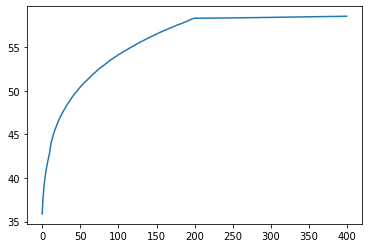

In [10]:
pow_model = np.zeros((L,))

for i in range(L):
    pow_model[i] = np.sum(w_glob_array_np[i,:]**2)

print(pow_model)
plt.plot(pow_model)
plt.show()

In [282]:
ModelDiff_np(w_locals_array_np[0,0,:], w_locals_array_np[0,5,:])

ModelDiff_np(w_locals_array_np[45,10,:], w_locals_array_np[59,10,:])

ModelDiff_np(w_glob_array_np[45,:], w_glob_array_np[75,:])

[[36.37815305]] [[36.46391591]] [[2.69061187]]
[[46.74763326]] [[48.76243624]] [[0.41891381]]
[[46.43291559]] [[50.04760274]] [[0.90370628]]


array([[0.01946262]])

In [11]:
P_random = np.array(P_random)

print(np.shape(P_random))

(400, 40)


In [13]:
# Verification
K=8
target_iter = 45

A_tmp = np.reshape(P_random[target_iter,:],(1,N))
B_tmp = w_locals_array_np[target_iter,:,:]

print(np.shape(A_tmp), np.shape(B_tmp))

w_glob_tmp_np = (1/K) * np.matmul(A_tmp,B_tmp)

print(np.shape(w_glob_tmp_np))

print('following two vector should be almost the same')
ModelDiff_np(w_glob_tmp_np, w_glob_array_np[target_iter,:])

(1, 40) (40, 62346)
(1, 62346)
following two vector should be almost the same
[[49.90893548]] [[49.90893545]] [[1.09473454e-13]]


array([[2.19346401e-15]])

In [14]:
w_glob_const_array_np = np.zeros((50,d))

for iter in range(150,200):
    sel_tmp = P_random[iter,:]
    sel_tmp = np.reshape(sel_tmp, (1,N))
    
    w_glob_const_array_np[iter-150,:] = np.matmul(sel_tmp, w_locals_array_np[150,:,:])
    

In [31]:
# Pseudo Inversion
P_random_tmp = P_random[260:300,:]

PT = P_random_tmp.transpose()

print(np.shape(PT))

PTP = np.matmul(P_random_tmp.transpose(), P_random_tmp)

print(np.linalg.matrix_rank(PTP))

PTP_inv=np.linalg.pinv(PTP)


# print(np.shape(PT), np.shape(w_glob_array_np[10:60,:]))
Pw_glob = np.matmul(PT, w_glob_array_np[260:300,:])
w_recon_np = K * np.matmul(PTP_inv, Pw_glob)

# ModelDiff_np(w_locals_array_np[-1,1,:], w_recon_np[1])
l2_diff = np.zeros((N))
for i in range(N-1):
    l2_diff[i] = ModelDiff_np(w_locals_array_np[260,i,:], (w_recon_np[i]+w_recon_np[i+1])/2)
print()
print()
l2_diff_ = np.zeros((N))
for i in range(N):
    l2_diff_[i] = ModelDiff_np(w_locals_array_np[260,i,:], w_recon_np[i])

print(np.sum(l2_diff)/N, np.sum(l2_diff_)/N)
# w_recon_np = K * np.matmul(pinv, w_glob_array_np[10:50,:])
# u, s, vh = np.linalg.svd(PTP, full_matrices=True)

# print(s)

(40, 40)
40
[[58.39033656]] [[58.63134631]] [[0.03932753]]
[[58.38185212]] [[58.65902873]] [[0.04925647]]
[[58.392595]] [[58.49128102]] [[0.01400947]]
[[58.38710484]] [[58.30686787]] [[0.07833325]]
[[58.39155459]] [[58.29052493]] [[0.11848116]]
[[58.38382129]] [[58.34737319]] [[0.00989908]]
[[58.39094244]] [[58.77321383]] [[0.13749505]]
[[58.39323288]] [[58.77108605]] [[0.07594316]]
[[58.38997573]] [[58.37442465]] [[0.064123]]
[[58.38517098]] [[58.27534052]] [[0.10182096]]
[[58.3923289]] [[58.35601891]] [[0.01166528]]
[[58.39190088]] [[58.792869]] [[0.3205879]]
[[58.3928183]] [[58.61128737]] [[0.14335802]]
[[58.38822846]] [[58.44549601]] [[0.00593101]]
[[58.39146831]] [[58.42311279]] [[0.01241602]]
[[58.38884893]] [[58.39442967]] [[0.00855837]]
[[58.39234214]] [[58.3654324]] [[0.00358714]]
[[58.39141851]] [[58.30290422]] [[0.01409152]]
[[58.39303516]] [[58.39551805]] [[0.01863328]]
[[58.39019939]] [[58.39020028]] [[0.01906681]]
[[58.39024512]] [[58.32666808]] [[0.02948972]]
[[58.387711

In [33]:
hist, bin_edges = np.histogram(l2_diff_)

print(hist)
print(bin_edges)

[24  8  1  3  2  0  1  0  0  1]
[5.34515133e-05 1.21438048e-03 2.37530944e-03 3.53623840e-03
 4.69716737e-03 5.85809633e-03 7.01902529e-03 8.17995426e-03
 9.34088322e-03 1.05018122e-02 1.16627411e-02]


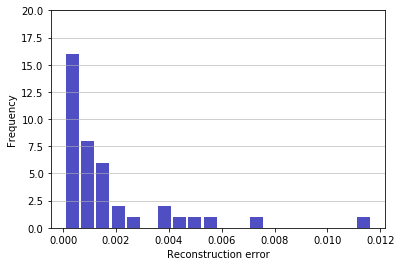

In [42]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=l2_diff_, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
# plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('./plots/error_histo.png',dpi=300, bbox_inches = "tight")
# plt.savefig('./plots/error_histo.eps', format='eps',dpi=300, bbox_inches = "tight")

In [ ]:
diff = np.zeros((N,N))

In [203]:
P_random_tmp = P_random[20:60,:]



print(np.linalg.matrix_rank(P_random_tmp))

pinv=np.linalg.pinv(P_random_tmp)

print((pinv))
print(pinv@P_random_tmp)

w_recon_np = K * np.matmul(pinv, w_glob_array_np[20:60,:])
# w_recon_const_np = np.matmul(pinv, w_glob_const_array_np[:,:])

print(np.shape(w_recon_np))

40
[[-0.12592153  0.19073155 -0.33113567 ... -0.58713839 -0.23970895
  -0.02077015]
 [ 0.02196346  0.00931958  0.08302567 ... -0.12958761  0.02791788
  -0.21650339]
 [-0.08537564  0.23366442 -0.14108336 ... -0.34402047 -0.13685602
  -0.15667227]
 ...
 [ 0.11000394 -0.72209218  0.40505864 ...  0.73575671  0.14326287
   0.23235877]
 [-0.29289279  0.53368763 -0.42441197 ... -0.17325909 -0.86651045
  -0.28190613]
 [ 0.00099611  0.0685103  -0.33417039 ... -0.74486814  0.17281757
  -0.30962181]]
[[ 1.00000000e+00  4.71844785e-16 -1.55431223e-15 ...  3.78169718e-16
  -1.22124533e-15 -1.11022302e-16]
 [-5.55111512e-17  1.00000000e+00 -1.02695630e-15 ... -8.32667268e-16
   5.27355937e-16  8.53483950e-16]
 [-1.11022302e-16 -2.49800181e-16  1.00000000e+00 ... -1.11022302e-16
  -2.77555756e-16  1.38777878e-15]
 ...
 [-3.33066907e-16  9.99200722e-16  1.60982339e-15 ...  1.00000000e+00
   0.00000000e+00 -2.27595720e-15]
 [ 1.11022302e-16 -1.44328993e-15 -3.05311332e-15 ... -2.72004641e-15
   1.00000

In [204]:
for i in range(40):
    ModelDiff_np(w_locals_array_np[-1,0,:], w_recon_np[i])

[[44.18547819]] [[44.19032681]] [[0.00061653]]
[[44.18547819]] [[44.1845069]] [[0.00023136]]
[[44.18547819]] [[44.18503901]] [[0.0004239]]
[[44.18547819]] [[44.19184781]] [[0.00064832]]
[[44.18547819]] [[44.18987874]] [[0.0006569]]
[[44.18547819]] [[44.18877092]] [[0.00153757]]
[[44.18547819]] [[44.19251795]] [[0.0020055]]
[[44.18547819]] [[44.18772894]] [[0.00198513]]
[[44.18547819]] [[44.1845114]] [[0.0024794]]
[[44.18547819]] [[44.18707573]] [[0.00209496]]
[[44.18547819]] [[44.18226602]] [[0.00044381]]
[[44.18547819]] [[44.19128346]] [[0.00052433]]
[[44.18547819]] [[44.18853467]] [[0.00027977]]
[[44.18547819]] [[44.18587752]] [[0.00041754]]
[[44.18547819]] [[44.1905458]] [[0.00077721]]
[[44.18547819]] [[44.18603927]] [[8.62301717e-05]]
[[44.18547819]] [[44.18980338]] [[0.00019002]]
[[44.18547819]] [[44.1848371]] [[0.00038909]]
[[44.18547819]] [[44.18543366]] [[0.00155818]]
[[44.18547819]] [[44.18546118]] [[0.00021386]]
[[44.18547819]] [[44.18504224]] [[0.00060313]]
[[44.18547819]] [

In [151]:
N_idx = 39

for i in range(N):
    ModelDiff_np(w_recon_const_np[0], w_recon_np[i])

# for iter in range(60,100):
#     print('iter=',iter)
#     ModelDiff_np(w_recon_np[N_idx], w_locals_array_np[iter,N_idx,:])
    
#     print()
#     print()

[[43.06451082]] [[242.78176678]] [[198.89164699]]
[[43.06451082]] [[49.00248279]] [[5.93024574]]
[[43.06451082]] [[71.02396262]] [[28.19891518]]
[[43.06451082]] [[57.79445856]] [[15.42293756]]
[[43.06451082]] [[128.0681452]] [[84.59117114]]
[[43.06451082]] [[47.74361787]] [[4.87251176]]
[[43.06451082]] [[275.89264727]] [[231.65863392]]
[[43.06451082]] [[108.01170228]] [[66.14991779]]
[[43.06451082]] [[83.97530446]] [[40.6710493]]
[[43.06451082]] [[72.63892956]] [[30.39607074]]
[[43.06451082]] [[110.71911139]] [[68.69398992]]
[[43.06451082]] [[75.55726117]] [[32.31464345]]
[[43.06451082]] [[52.50503152]] [[9.26818622]]
[[43.06451082]] [[95.71407425]] [[52.22102977]]
[[43.06451082]] [[62.83548657]] [[19.65563078]]
[[43.06451082]] [[376.17618668]] [[335.19284061]]
[[43.06451082]] [[75.99301597]] [[32.4771955]]
[[43.06451082]] [[59.85580472]] [[17.36470655]]
[[43.06451082]] [[51.59183333]] [[8.84309868]]
[[43.06451082]] [[53.28618831]] [[10.78558961]]
[[43.06451082]] [[50.30140388]] [[7.72

In [164]:
u, s, vh = np.linalg.svd(P_random_tmp, full_matrices=True)

print(s)

[8.46235478e+00 4.68852291e+00 4.51060146e+00 4.40417201e+00
 4.08531140e+00 3.91543416e+00 3.82145746e+00 3.62875652e+00
 3.55702060e+00 3.44484337e+00 3.31225541e+00 3.14160056e+00
 2.98825380e+00 2.83726526e+00 2.76915884e+00 2.56257634e+00
 2.49441954e+00 2.35429766e+00 2.26961498e+00 2.14687796e+00
 2.04901805e+00 1.98527167e+00 1.83084679e+00 1.72387391e+00
 1.67487440e+00 1.51330718e+00 1.44416214e+00 1.24052550e+00
 1.17100295e+00 9.51581599e-01 9.04429617e-01 8.79298746e-01
 8.24320020e-01 6.69990656e-01 5.34550525e-01 4.24449771e-01
 2.75195221e-01 2.01619422e-01 1.02146994e-01 6.59999616e-04]


In [ ]:
w_recon = 